In [1]:
import pandas as pd
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

데이터 불러오기

In [2]:
def filter_df(df): #데이터프레임 필터링
    # 첫 번째 열에서 같은 값을 가진 행의 수를 계산합니다.
    row_counts = df['0'].value_counts()

    # 가장 많은 행의 수를 찾습니다.
    max_row_count = row_counts.max()

    # 가장 많은 행의 수에 해당하는 행만 분류합니다.
    filtered = pd.DataFrame(df[df['0'].isin(row_counts[row_counts == max_row_count].index)])

    return filtered

# 데이터 로드   
pred_df = pd.read_csv('/Users/moon/Desktop/Moon SeungHoo/Stock_Machine_Learning/StockData_Pred_1109.csv',low_memory=False)

filter_pred= filter_df(pred_df)

# 예측에 필요한 데이터 
pred_ticker = filter_pred['0'].tolist() #종목코드 저장

# 불필요한 데이터 삭제
filter_pred = filter_pred.drop({'0','1','7'},axis=1) #종목코드, 날자, 상승율 삭제

학습한 모델 불러오기

In [3]:
# 모델 로드
loaded_model = tf.keras.models.load_model("GRU_Model_7L_64.h5")

예측

In [4]:
T_pred = loaded_model.predict(filter_pred)

224/224 [==============================] - 3s 10ms/step


예측한 결과 확인

In [5]:
def make_six_digit_list(input_list):
    six_digit_list = []

    for item in input_list:
        # 현재 항목의 길이를 확인
        item_str = str(item)
        item_len = len(item_str)

        if item_len < 6:
            # 6자리가 안되는 항목은 앞에 0을 채워서 6자리로 만듭니다.
            zero_padding = '0' * (6 - item_len)
            six_digit_item = zero_padding + item_str
            six_digit_list.append(six_digit_item)
        else:
            # 이미 6자리인 경우 그대로 유지
            six_digit_list.append(item_str)

    return six_digit_list

In [6]:
# 5% 이상 오를 종목 식별
rising_stocks = [ticker for i, ticker in enumerate(pred_ticker) if T_pred[i] > 0.9]

# T_pred를 기준으로 내림차순 정렬
rising_stocks_sorted = sorted(rising_stocks, key=lambda i: T_pred[pred_ticker.index(i)], reverse=True)
rising_stocks_sorted = list(map(str, rising_stocks_sorted))
result = list(set(rising_stocks_sorted))
result = make_six_digit_list(result)
print("내일 5% 이상 상승할 종목:", result)
print(len(result))

내일 5% 이상 상승할 종목: ['080220', '383310', '007160', '185750', '221800']
5


            Open  High   Low  Close   Volume    Change
Date                                                  
2023-11-08  4970  5030  4800   4800  1827375 -0.025381
             Open   High    Low  Close  Volume    Change
Date                                                    
2023-11-08  68000  70200  65100  65900  295686 -0.069209
             Open   High    Low  Close  Volume   Change
Date                                                   
2023-11-08  40650  40900  40100  40600    4871 -0.00123
              Open    High     Low   Close  Volume  Change
Date                                                      
2023-11-08  129500  132600  127100  129500  537932     0.0
            Open  High   Low  Close   Volume    Change
Date                                                  
2023-11-08  7010  7700  6640   6800  3345468 -0.051604


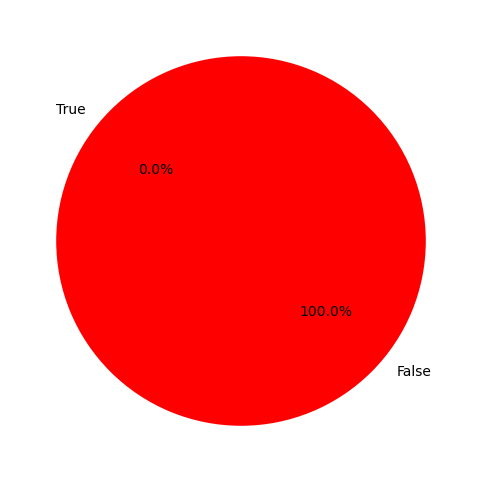

In [7]:
def check_price_increase(stock_codes):
    result = {}
    
    for code in stock_codes:
        df = fdr.DataReader(code,'2023-11-08','2023-11-09')
        print(df)
        if len(df) < 2:
            result[code] = False
        else:
            today_close = df['Change'].iloc[-1]

            if today_close >=  0.05:
                result[code] = True
            else:
                result[code] = False
    return result

result_TF = check_price_increase(result)
result_TF = list(result_TF.values())

# True와 False의 개수를 세어 비율을 계산
true_count = sum(result_TF)
false_count = len(result_TF) - true_count

# 비율을 파이그래프로 표현
labels = ['True', 'False']
sizes = [true_count, false_count]
colors = ['green', 'red']

# 파이차트 그리기
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# 그래프 표시
plt.show() 